In [22]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as torchNN
import torch.nn.functional as torchF
import matplotlib.pyplot as plt
import gymnasium as gym

from itertools import count
from IPython import display
from collections import namedtuple, deque

%matplotlib inline

In [23]:
Transition = namedtuple('Transition', ('nowState', 'action', 'nextState', 'reward'))
class MemoryPool():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen = capacity)
    
    def AddMemory(self, *arg):
        self.memory.append(Transition(*arg))
    
    def Sample(self, BATCHSIZE):
        return random.sample(self.memory, BATCHSIZE)

    def __len__(self):
        return len(self.memory)

In [24]:
# Add network policy and target
class Network(torchNN.Module):
    def __init__(self, stateNum, actionNum, hiddenUnits) -> None:
        super().__init__()
        self.liner = torchNN.Sequential(
            torchNN.Linear(stateNum, hiddenUnits),
            torchNN.LeakyReLU(),
            torchNN.Linear(hiddenUnits, hiddenUnits),
            torchNN.LeakyReLU(),
            torchNN.Linear(hiddenUnits, actionNum),
        )

    def forward(self, nowState):
        return self.liner(nowState)

In [25]:
class DQNModel():
    def __init__(
        self,
        stateNum,
        actionNum,
        hiddenUnits,
        episold,
        poolCapacity,
        environment,
        learningRate,
        batchSize,
        gamma,
        sigma,
    ):
        '''
        Param:
            stateNum: 
            actionNum:
            hiddenUnits:
            episold:
            poolCapacity:
            environment:
            learningRate:
            gamma:
            sigma:
        '''

        self.policyNetwork = Network(stateNum, actionNum, hiddenUnits)
        self.targetNetwork = Network(stateNum, actionNum, hiddenUnits)

        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())

        self.episold = episold
        self.memoryPool = MemoryPool(poolCapacity)
        self.environment = environment
        self.optimizer = torch.optim.Adam(self.policyNetwork.parameters(), lr = learningRate)
        self.lossFunc = torchNN.SmoothL1Loss()                      # use L1 lossfunction
        self.batchSize = batchSize
        self.gamma = gamma
        self.sigma = sigma

    def LoadNetwork(self, savedPath):
        self.policyNetwork.load_state_dict(torch.load(savedPath))
        self.targetNetwork.load_state_dict(torch.load(savedPath))

    def SaveNetwork(self, savedPath):
        torch.save(self.policyNetwork.state_dict(), savedPath)
    
    def ChooseAction(self, nowState) -> torch.Tensor:
        '''
        Func:
            return the next action agent may take
        Param:
            nowState:   the state agent is in
        Return:
            shape:      (1, 1), the first d is used for 'BatchSize'      
        '''
        if random.random() < self.episold:
            return torch.tensor([[self.environment.action_space.sample()]], dtype = torch.long)
        with torch.no_grad():
            return self.policyNetwork(nowState).max(1).indices.view(1, 1)   

    def OptimizeNetwork(self):
        if len(self.memoryPool) < self.batchSize:
            return

        data = self.memoryPool.Sample(self.batchSize)
        data = Transition(*zip(*data))

        # 剔除结束回合的步子
        noneFinalNextStateMask = torch.tensor( tuple( map( lambda state: state is not None, data.nextState ) ), dtype = torch.bool)     # shape do not change
        noneFinalnextState = torch.cat( [state for state in data.nextState if state is not None] )

        nowStateMemory = torch.cat(data.nowState)
        actionMemory = torch.cat(data.action)
        rewardMemory = torch.cat(data.reward)

        predictQ = self.policyNetwork(nowStateMemory).gather(1, actionMemory)

        targetQ = torch.zeros(self.batchSize)
        with torch.no_grad():
            targetQ[noneFinalNextStateMask] = self.targetNetwork(noneFinalnextState).max(1).values                                      # 求最大值, 但是凭借成BATCHSIZE的大小, 方便进行数学运算
        targetQ = (targetQ * self.gamma) + rewardMemory

        loss = self.lossFunc(targetQ.unsqueeze(1), predictQ)
        
        self.optimizer.zero_grad()
        loss.backward()
        torchNN.utils.clip_grad_value_(self.policyNetwork.parameters(), 100)

        self.optimizer.step()

        return loss.data.numpy()


    def TrainOneEpoch(self):
        '''
        Func:
        Return:
        '''
        startState, info = self.environment.reset()
        nowState = torch.tensor(startState, dtype = torch.float32).unsqueeze(0)

        for stepNum in count():
            action = self.ChooseAction(nowState)
            observation, reward, terminated, truncated, _ = self.environment.step(action.item())
            reward = torch.tensor([reward])
            done = terminated or truncated

            if terminated:
                nextState = None
            else:
                nextState = torch.tensor(observation, dtype = torch.float32).unsqueeze(0)
            
            self.memoryPool.AddMemory(nowState, action, nextState, reward)

            nowState = nextState

            self.OptimizeNetwork()

            targetNetworkDict = self.targetNetwork.state_dict()
            policyNetworkDict = self.policyNetwork.state_dict()

            for key in policyNetworkDict:
                targetNetworkDict[key] = policyNetworkDict[key] * self.sigma + targetNetworkDict[key] * (1 - self.sigma)
            self.targetNetwork.load_state_dict(targetNetworkDict)

            if done:
                return stepNum + 1

In [26]:
env = gym.make("CartPole-v1")
STATENUM = env.observation_space.shape[0]
ACTIONNUM = env.action_space.n
HIDDENUNITS = 128
EPISOLD = 0.6
POOLCAPACITY = 10000
LR = 0.003
BATCHSIZE = 128
GAMMA = 0.9
SIGMA = 0.005
EPOCHES = 300
SAVEDPATH = '../SavedModel/DQN/dqn1.pth'
CALLBACK = '../CallBack/DQN/dqn1.csv'

dqnNetwork = DQNModel(
    STATENUM,
    ACTIONNUM,
    HIDDENUNITS,
    EPISOLD,
    POOLCAPACITY,
    env,
    LR,
    BATCHSIZE,
    GAMMA,
    SIGMA
)

In [27]:
if os.path.exists(SAVEDPATH):
    dqnNetwork.LoadNetwork(SAVEDPATH)

history = {
    'step': [],
}

if os.path.exists(CALLBACK):
    backValue = pd.read_csv(CALLBACK)
    history['step'] += list(backValue['step'])
meanPlot = 0
for i in range(EPOCHES):
    step = dqnNetwork.TrainOneEpoch()
    history['step'].append(step)
    meanPlot += step
    if (i + 1) % 10 == 0:
        dqnNetwork.SaveNetwork(SAVEDPATH)

meanPlot /= EPOCHES
print(meanPlot)
callbackCSV = pd.DataFrame(history)
callbackCSV.to_csv(CALLBACK)

25.362666666666666


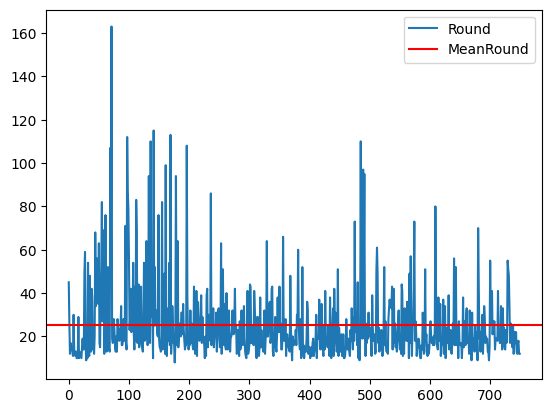

In [28]:
plt.plot(history['step'], label = 'Round')
plt.axhline(y = meanPlot, xmin = 0, xmax = 1, label = 'MeanRound', color = 'red')
plt.legend()